In [0]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm

from torch.nn.parameter import Parameter
import pdb
 
assert torch.cuda.is_available()                                                # You need to request a GPU from Runtime > Change Runtime Type

Number of Parameters:
1099780


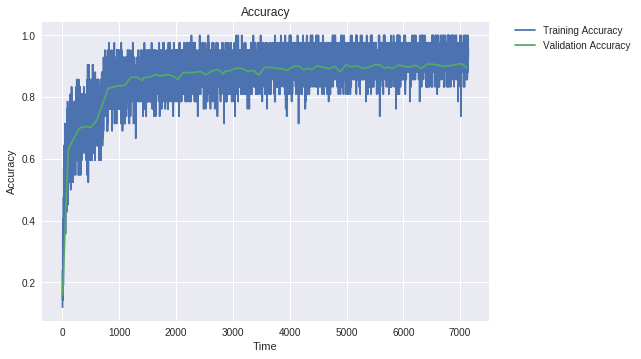

In [88]:
# Conv Model Class
class ConvNetwork(nn.Module):
  def __init__(self, data):
    super(ConvNetwork, self).__init__()
    x, y = data[0]
    c, h, w = x.size()
    out = 10
    
    self.net = nn.Sequential(                                                   # Add conv layers to DNN
      Conv2d(c, 10, (5, 5), padding=(1,1), init="orthogonal"),
      nn.ReLU(),
      Conv2d(10, 100, (5, 5), padding=(1,1), init="orthogonal"),
      nn.ReLU(),
      Conv2d(100, 100, (5, 5), padding=(1,1), init="orthogonal"),
      nn.ReLU(),
      Conv2d(100, 100, (5, 5), padding=(1,1), init="orthogonal"),
      nn.ReLU(),
      Conv2d(100, 100, (5, 5), padding=(1,1), init="orthogonal"),
      nn.ReLU(),
      Conv2d(100, 10, (18, 18), padding=(0,0), init="orthogonal"),
      nn.ReLU(),
      Conv2d(10, out, (1, 1), padding=(0,0), init="orthogonal")                 # Finish with (10,1,1)
    )
    
  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)
  

# 2d Conv Class
class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
               padding=0, dialation=1, groups=1, bias=True, init="uniform"):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()
    self.init_prams()
  
  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding,       # Do convolution
                    self.dialation, self.groups)
  
  def init_prams(self):
    self.bias = Parameter(torch.Tensor(self.out_channels))
    self.bias.data.uniform_(0, 0)                                               # Set bias to zero
    
    if self.init == "orthogonal":
      R = np.random.random((self.out_channels, 
                            self.in_channels * self.kernel_size[0] * self.kernel_size[1]))
      U, _, V = np.linalg.svd(R, full_matrices=False)
      X = U if U.shape == R.shape else V
      W = X.reshape((self.out_channels, self.in_channels, *self.kernel_size))
      self.weight = Parameter(torch.Tensor(W))                                  # Init weights with orthogonal matrix
      
    elif self.init == "xavier":
      self.weight = Parameter(torch.Tensor(self.out_channels, 
                                           self.in_channels, 
                                           *self.kernel_size))
      nn.init.xavier_uniform_(self.weight)                                      # Init weights with xavier initialization 
      
    else:
      self.weight = Parameter(torch.Tensor(self.out_channels, 
                                           self.in_channels, 
                                           *self.kernel_size))
      self.weight.data.uniform_(-1, 1)                                          # Init weights with uniform random
    
  
# Loss class
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, 
             reduce=None, reduction='elementwise_mean'):
    self.__dict__.update(locals())
    super(CrossEntropyLoss, self).__init__()

  def forward(self, logits, targets): 
    for i in logits:                                                            # Use logsumexp to normalize
      i -= max(i)  
      
    num = torch.exp(logits)                                                     # Calculate softmax               
    den = num.sum(1, keepdim=True)
    softmax = num / den            
    log_softmax = torch.log(softmax)
    
    i = torch.arange(log_softmax.size(0))                                       # Get cross entropy
    res = log_softmax[i, targets]
    
    return -res.mean()
  
  
# Data class
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root,                                     # Imports dataset
                                      train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
    
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y                                                                 # Puts returns data from dataset
  
  def __len__(self):
    return len(self.data)                                                       # Length of data
  
  
# Init objects
EPOCHS = 5
  
data_train = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)      # Get data
data_test = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

model = ConvNetwork(data_train)                                                 # Init model
model = model.cuda()         

loader_train = DataLoader(data_train,                                           # Init Data Loader
                          batch_size=42,
                          pin_memory=True)

loader_test = DataLoader(data_test, 
                         batch_size=42,
                         pin_memory=True)

objective = CrossEntropyLoss()                                                  # Set loss function

optimizer = optim.Adam(model.parameters(), lr=1e-4)                             # Optimize our wieghts and biases

accuracy_train = []
accuracy_test = []

# Start training
for epoch in range(EPOCHS):
  
  loop = tqdm(total=len(loader_train), position=0, leave=False)
  
  # Train batch
  for batch, (x, y_truth) in enumerate(loader_train):                 
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)       
    
    optimizer.zero_grad()
    y_hat = model(x)                                                            # Get prediction from model
    
    loss = objective(y_hat, y_truth)                                            # Calculate loss
    
    loss.backward()
    optimizer.step()                                                            # Take Step
    
    accuracy = (y_hat.argmax(1) == y_truth).float().mean()
    accuracy_train.append(accuracy)
    loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.4f}'
                         .format(epoch, loss.item(), accuracy))
    loop.update(1)
    
    # Test
    if batch % 100 == 0:                                                        # Run validation loop every 100 instances
      accuracy = np.mean([(model(x.cuda()).argmax(1) == y.cuda()).float().mean() 
                          for x, y in loader_test])
      accuracy_test.append((len(accuracy_train), accuracy))
    
  loop.close()

# Print Parameters
prams = [np.prod(p.size()) for p in model.parameters()]
pram_count = np.sum(prams)

print("Number of Parameters:")
print(pram_count)

# Plot results
x_test, y_test = zip(*accuracy_test)
plt.plot(accuracy_train, label="Training Accuracy")
plt.plot(x_test, y_test, label="Validation Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Accuracy")
plt.xlabel("Time")
plt.ylabel("Accuracy")

plt.show()
  

Using a Kernel size of 3×3:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3, 3), padding=(1, 1))

(c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size=(3, 3), padding=(2, 2))

(c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size=(3, 3), padding=(6, 6))

Using a Kernel size of 5×5:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 5), padding=(2, 2))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 5), padding=(3, 3))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 5), padding=(9, 9))

Using Kernel size of 5×3:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 3), padding=(1, 0))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 3), padding=(2, 1))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 3), padding=(3, 2))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 3), padding=(9, 8))

Determine the kernel that requires the smallest padding size to make the following mappings possible:

(c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels=10, kernel_size=(2, 4), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(1, 1), padding=(0, 0))